# Importing the required libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, roc_curve,
                             roc_auc_score, confusion_matrix,
                             f1_score, log_loss)

%matplotlib inline

# Loading the dataset

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
X_train, y_train = (train_data.drop('class of diagnosis', axis=1),
                    train_data['class of diagnosis'])
X_test, y_test = test_data.drop('class of diagnosis', axis=1), test_data['class of diagnosis']
seed = 123

# Hyperparameter tuning

In [3]:
model = RandomForestClassifier(n_estimators= 100, random_state=seed, n_jobs=-1)

In [4]:
param_grid1 = {
    'n_estimators': [10, 100, 500, 1000]
}

grid_search1 = GridSearchCV(model, param_grid=param_grid1, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search1.fit(X_train, y_train)
model1 = grid_search1.best_estimator_
best1 = grid_search1.best_params_
print('Parameters chosen:')
print(*['{}: {}'.format(parameter, value)
        for parameter, value in zip(best1.keys(), best1.values())], sep='\n')

Parameters chosen:
n_estimators: 100


In [5]:
param_grid2 = {
    'max_depth': [3, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2,6,10],
    'min_samples_leaf': [1, 3, 5]
}

grid_search2 = GridSearchCV(model, param_grid=param_grid2, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search2.fit(X_train, y_train)
model2 = grid_search2.best_estimator_
best2 = grid_search2.best_params_
print('Parameters chosen:')
print(*['{}: {}'.format(parameter, value) 
        for parameter, value in zip(best2.keys(), best2.values())], sep='\n')

grid_model = model2


Parameters chosen:
max_depth: None
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2


# Model evaluation

#### Various metrics

In [6]:
folds = StratifiedKFold(n_splits=3, random_state=seed)

print('Evaluataion with 3-fold cross validation:')
for metric in ('accuracy', 'neg_log_loss', 'f1', 'roc_auc'):
    score = np.mean(cross_val_score(grid_model,
                                    X_train,
                                    y_train,
                                    scoring=metric,
                                    cv=folds,
                                    n_jobs=-1))
    print('{:<10}\t {}'.format(metric, score))


Evaluataion with 3-fold cross validation:
accuracy  	 0.7219549140158602
neg_log_loss	 -0.5889107936798564
f1        	 0.19866518353726362
roc_auc   	 0.6369690311780706


#### Feature importance

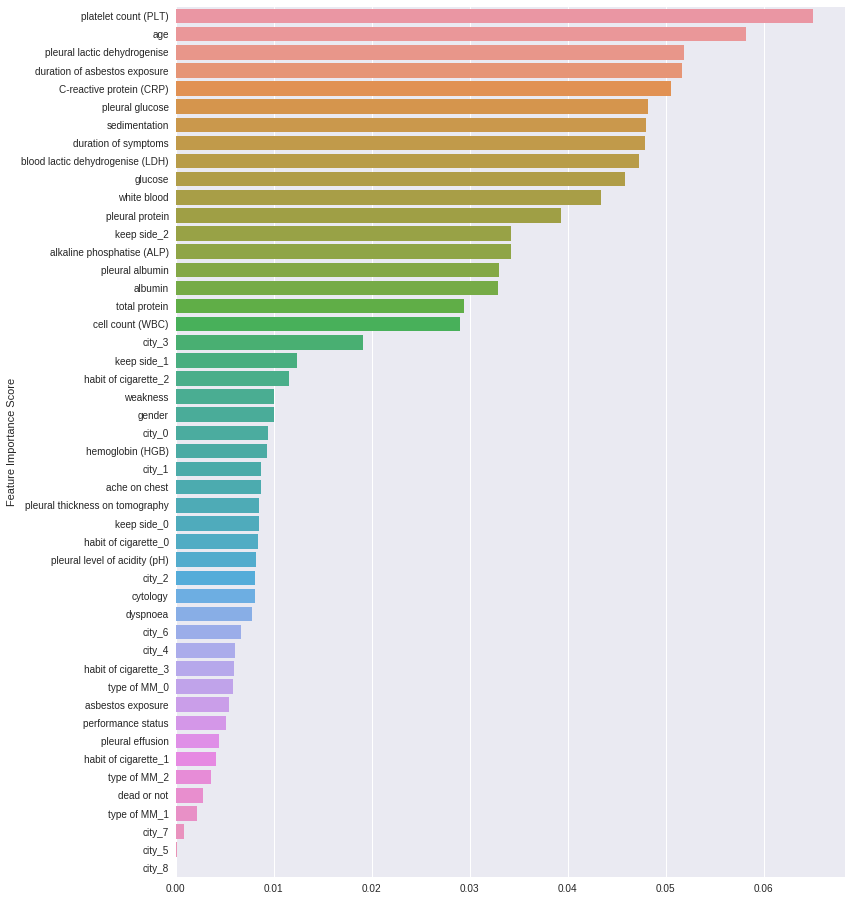

In [7]:
f_imp = pd.Series(grid_model.feature_importances_, X_train.columns)
f_imp = f_imp.sort_values(ascending=False)
plt.figure(figsize=(12,16))
f_imp_plot = sns.barplot(y=f_imp.index, x=f_imp.values)
plt.ylabel('Feature Importance Score')
plt.show()

### We can see a sudden drop in feature importance after 'cell count (WBC)'. Let's drop the less important features and train the model on that.

In [8]:
high_importance = f_imp[f_imp > f_imp['cell count (WBC)']].index
new_X_train = X_train[high_importance]
print('Evaluataion with 3-fold cross validation:')
for metric in ('accuracy', 'neg_log_loss', 'f1', 'roc_auc'):
    score = np.mean(cross_val_score(grid_model,
                                    new_X_train,
                                    y_train,
                                    scoring=metric,
                                    cv=3,
                                    n_jobs=-1))
    print('{:<10}\t {}'.format(metric, score))

Evaluataion with 3-fold cross validation:
accuracy  	 0.706673794885503
neg_log_loss	 -0.6062932976864617
f1        	 0.3333333333333333
roc_auc   	 0.6181802329636604


### Doesn't seem to be much of an improvement. Let's train the model on the original dataset

In [9]:
grid_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

# Performance on the test set

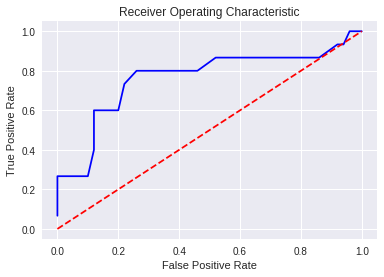

Area under curve: 0.762


In [10]:
fpr, tpr, thresholds = roc_curve(y_test, grid_model.predict_proba(X_test).T[1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc = roc_auc_score(y_test, grid_model.predict_proba(X_test).T[1])
print(''.join(('Area under curve: ', str(roc_auc))))